In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import simpy as sp
import time
import random
def print_np(x):
    print ("Type is %s" % (type(x)))
    print ("Shape is %s" % (x.shape,))
#     print ("Values are: \n%s" % (x))

In [2]:
import os
import sys
sys.path.append('./')
sys.path.append('../SCvx/')
sys.path.append('../SCvx/model')
sys.path.append('../SCvx/cost')
sys.path.append('../SCvx/constraints')
sys.path.append('../SCvx/sensor')
sys.path.append('../SCvx/utils')

In [3]:
import UnicycleModel
import UnicycleCost
import UnicycleConstraints
from scipy.integrate import solve_ivp
from Scvx import Scvx
import cvxpy as cvx
from Scaling import compute_scaling

In [4]:
ix = 4
iu = 2
ih = 1
N = 30
delT = 0.1

In [5]:
A = np.eye(4)
A[0,2] = delT
A[1,3] = delT
print(A)
A = np.tile(A,(N,1,1))

B = np.zeros((4,2))
B[2,0] = delT
B[3,1] = delT
print(B)
B = np.tile(B,(N,1,1))

[[1.  0.  0.1 0. ]
 [0.  1.  0.  0.1]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]]
[[0.  0. ]
 [0.  0. ]
 [0.1 0. ]
 [0.  0.1]]


In [6]:
print_np(A)
print_np(B)

Type is <class 'numpy.ndarray'>
Shape is (30, 4, 4)
Type is <class 'numpy.ndarray'>
Shape is (30, 4, 2)


In [7]:
# initial condition
xi = np.array([0,0,0,0])
xf = np.array([1,1,0,0])

# initial trajectory
x0 = np.zeros((N+1,ix))
for i in range(N+1) :
    x0[i] = (N-i)/N * xi + i/N * xf
u0 = np.zeros((N+1,iu))

# obstacle
c = np.array([0.45,0.55])
r = 0.2
H = np.diag(np.array([1/r,1/r]))

# cost
cost_R = np.eye(iu)
w_tr = 1e-3

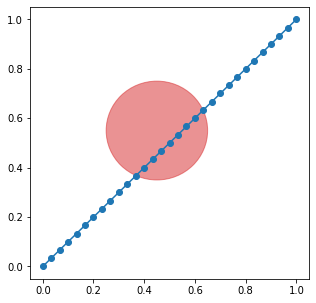

In [8]:
plt.figure(figsize=(5,5))
ax=plt.gca()
circle1 = plt.Circle((c[0],c[1]),r,color='tab:red',alpha=0.5,fill=True)
ax.add_patch(circle1)
plt.plot(x0[:,0],x0[:,1],color='tab:blue',linestyle='-')
plt.plot(x0[:,0],x0[:,1],'o',color='tab:blue')

In [9]:
def get_obs_const(c,H,x_bar) :
    tmp1 = 1 - np.linalg.norm(H@(x_bar[0:2]-c))
    tmp2 = (H.T@H@(x_bar[0:2]-c)/np.linalg.norm(H@(x_bar[0:2]-c))).T
    a = - np.expand_dims(tmp2,1)
    b = - tmp1 - tmp2@x_bar[0:2]
    return  a,b
    

def cvxopt(x0,u0) :
    # scaling
    Sx,iSx,sx,Su,iSu,su = compute_scaling(x0,u0)

    # variable
    x_cvx = cvx.Variable((N+1,ix))
    u_cvx = cvx.Variable((N+1,iu))

    constraints = []
    # boundary condition
    constraints.append(Sx@x_cvx[0]+sx == xi)
    constraints.append(Sx@x_cvx[-1]+sx == xf)
    # constraints
    for i in range(0,N) :
        # model
        constraints.append(Sx@x_cvx[i+1]+sx == A[i]@(Sx@x_cvx[i]+sx)+B[i]@(Su@u_cvx[i]+su))
        # constraint
        a,b = get_obs_const(c,H,x0[i])
        cH = np.array([[1,0,0,0],[0,1,0,0]])
        constraints.append(a.T@cH@(Sx@x_cvx[i]+sx)<=b)

    # objective
    objective = []
    for i in range(0,N) :
        objective.append(cvx.quad_form(Su@u_cvx[i]+su,cost_R))
        
    # objective_tr = []
    # for i in range(0,N) :
    #     objective_tr.append( w_tr * (cvx.quad_form(Sx@x_cvx[i]+sx -
    #                     x0[i],np.eye(ix)) + cvx.quad_form(Su@u_cvx[i]+su-u0[i],np.eye(iu))))

    l = cvx.sum(objective)
    # l_tr = cvx.sum(objective_tr)
    l_all = l

    prob = cvx.Problem(cvx.Minimize(l_all), constraints)
    prob.solve()#verbose=False,solver=cvx.ECOS,warm_start=True)
    print(prob.status)
    x_new = np.zeros_like(x0)
    u_new = np.zeros_like(u0)
    for i in range(N+1) :
        x_new[i] = Sx@x_cvx[i].value + sx
        u_new[i] = Su@u_cvx[i].value + su
    return x_new,u_new

In [10]:
max_iter = 10
x_bar,u_bar = x0,u0
for i in range(max_iter) :
    x_new,u_new = cvxopt(x_bar,u_bar)
    x_bar,u_bar = x_new,u_new

optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal


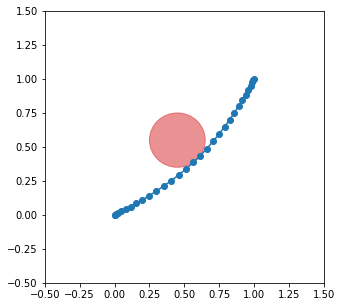

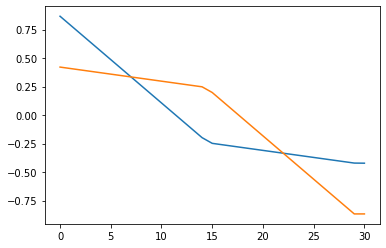

In [11]:
plt.figure(figsize=(5,5))
ax=plt.gca()
circle1 = plt.Circle((c[0],c[1]),r,color='tab:red',alpha=0.5,fill=True)
ax.add_patch(circle1)
plt.plot(x_new[:,0],x_new[:,1],color='tab:blue',linestyle='-')
plt.plot(x_new[:,0],x_new[:,1],'o',color='tab:blue')
plt.axis([-0.5, 1.5, -0.5, 1.5])
plt.figure()
plt.plot(u_new[:,0])
plt.plot(u_new[:,1])

In [41]:
from cvxpy.atoms.log_det import log_det
rho = 0.99
def cvxopt_sdp(x0,u0,Q0) :
    
    
    # scaling
    Sx,iSx,sx,Su,iSu,su = compute_scaling(x0,u0)

    # variable
    x_cvx = cvx.Variable((N+1,ix))
    u_cvx = cvx.Variable((N+1,iu))
    Q_list = []
    Y_list = []
    for i in range(N+1) :
        Q_list.append(cvx.Variable((ix,ix), PSD=True))
        Y_list.append(cvx.Variable((iu,ix)))
    
    constraints = []
    
    # boundary condition
    constraints.append(Sx@x_cvx[0]+sx == xi)
    constraints.append(Sx@x_cvx[-1]+sx == xf)
    
    # constraints
    # obstacle
    cH = np.array([[1,0,0,0],[0,1,0,0]])
    for i in range(0,N+1) :
        Qi = Sx@Q_list[i]@Sx
        Yi = Su@Y_list[i]@Sx
        if i < N :
            Qi_next = Sx@Q_list[i+1]@Sx
    
        if i < N :
            # model
            constraints.append(Sx@x_cvx[i+1]+sx == A[i]@(Sx@x_cvx[i]+sx)+B[i]@(Su@u_cvx[i]+su))

            # Lyapunov stability
            tmp1 = cvx.hstack((rho*Qi,Qi@A[i].T + Yi.T@B[i].T))
            tmp2 = cvx.hstack((A[i]@Qi+B[i]@Yi,Qi_next))
            left1 = cvx.vstack((tmp1,tmp2))
            constraints.append(left1 >> 0)
        
        # constraint
        a,b = get_obs_const(c,H,x0[i])
        h_Q0 = np.sqrt(a.T@Q0[i][0:2,0:2]@a)
        partial_h = 0.5 * 1 / h_Q0 * a@a.T 
        constraints.append(h_Q0 + cvx.trace(partial_h.T@(Qi[0:2,0:2]-Q0[i][0:2,0:2]))+a.T@cH@(Sx@x_cvx[i]+sx)<=b)
        constraints.append(Qi << 0.2*np.eye(ix))

    
    # objective
    objective = []
    for i in range(0,N+1) :
        objective.append(cvx.quad_form(Su@u_cvx[i]+su,cost_R))
    
    objective_Q = []
    for i in range(0,N+1) :
        objective_Q.append(-0.4*log_det(Sx@Q_list[i]@Sx))
        
    # objective_tr = []
    # for i in range(0,N) :
    #     objective_tr.append( w_tr * (cvx.quad_form(Sx@x_cvx[i]+sx -
    #                     x0[i],np.eye(ix)) + cvx.quad_form(Su@u_cvx[i]+su-u0[i],np.eye(iu))))

    l = cvx.sum(objective)
    # l_tr = cvx.sum(objective_tr)
    l_Q = cvx.sum(objective_Q)
    l_all = l + l_Q

    prob = cvx.Problem(cvx.Minimize(l_all), constraints)
    prob.solve()#verbose=False,solver=cvx.ECOS,warm_start=True)
    print(prob.status,l_all.value)
    x_new = np.zeros_like(x0)
    u_new = np.zeros_like(u0)
    for i in range(N+1) :
        x_new[i] = Sx@x_cvx[i].value + sx
        u_new[i] = Su@u_cvx[i].value + su
        
    Q_new = []
    Y_new = []
    for i in range(N+1) :
        Q_new.append(Sx@Q_list[i].value@Sx)
        if i < N :
            Y_new.append(Su@Y_list[i].value@Sx)
    K_new = []
    for i in range(N) :
        K = Y_new[i]@np.linalg.inv(Q_new[i])
        K_new.append(K)
    K_new = np.array(K_new)
    return x_new,u_new,Q_new,Y_new,K_new

In [42]:
Q0 = np.eye(4) * 0.01
Q0 = np.tile(Q0,(N+1,1,1))

In [44]:
max_iter = 20
x_bar,u_bar,Q_bar = x0,u0,Q0
for i in range(max_iter) :
    print(i)
    x_new,u_new,Q_new,Y_new,K_new = cvxopt_sdp(x_bar,u_bar,Q_bar)
    x_bar,u_bar,Q_bar = x_new,u_new,Q_new

0
optimal 124.46237755119772
1
optimal 113.17582984661371
2
optimal 111.83298002940953
3
optimal 111.57950939831674
4
optimal 111.5120285910289
5
optimal 111.48938593599351
6
optimal 111.48131626290052
7
optimal 111.47834603825224
8
optimal 111.47723837608387
9
optimal 111.4768200751042
10
optimal 111.47666279966484
11
optimal 111.47660261513168
12
optimal 111.4765800224581
13
optimal 111.4765711578814
14
optimal 111.47656763404937
15
optimal 111.47656650995981
16
optimal 111.47656603997535
17
optimal 111.47656585772874
18
optimal 111.47656578235875
19
optimal 111.47656580277496


In [45]:
ellipse_list = []
theta = np.linspace(0,2*np.pi,30)
c_r = 1
circle_x = c_r * np.cos(theta) 
circle_y = c_r * np.sin(theta) 
circle = np.vstack((circle_x,circle_y))
for i in range(N) :
    Q_tmp = Q_new[i][0:2,0:2]
    L = np.linalg.cholesky(np.linalg.inv(Q_tmp))
    c_r = 1 * (rho ** i)
    circle_x = c_r * np.cos(theta) 
    circle_y = c_r * np.sin(theta) 
    circle = np.vstack((circle_x,circle_y)) 
    ellipse = np.linalg.inv(L.T)@circle
    ellipse_list.append(ellipse)

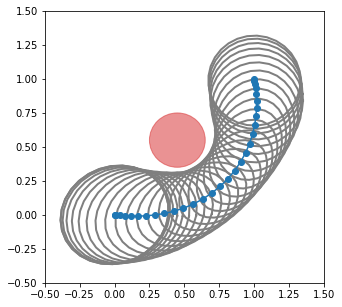

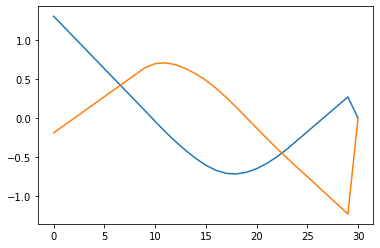

In [46]:
plt.figure(figsize=(5,5))
ax=plt.gca()
circle1 = plt.Circle((c[0],c[1]),r,color='tab:red',alpha=0.5,fill=True)
ax.add_patch(circle1)
for i in range(N) :
    plt.plot(ellipse_list[i][0,:]+x_new[i,0],ellipse_list[i][1,:]+x_new[i,1], linewidth=2.0,color='tab:grey')
plt.plot(x_new[:,0],x_new[:,1],color='tab:blue',linestyle='-')
plt.plot(x_new[:,0],x_new[:,1],'o',color='tab:blue')
plt.axis([-0.5, 1.5, -0.5, 1.5])
plt.figure()
plt.plot(u_new[:,0])
plt.plot(u_new[:,1])

## feedback gain test

In [ ]:
N_sample = 5
xdata = np.zeros((N_sample,N+1,ix))
udata = np.zeros((N_sample,N+1,iu))
std_position = [0.1,0.1,0.1,0.1]

for j in range(N_sample) :
    xdata[j,0] = x_new[0] + np.random.randn(ix) * np.array(std_position)
    for i in range(N) :
        udata[j,i] = u_new[i]+K_new[i]@(xdata[j,i]-x_new[i])
        xdata[j,i+1] = A[i]@xdata[j,i]+B[i]@udata[j,i]
        # xdata[j,i+1] = xbar[i+1] + np.random.randn(ix) * np.array(noise_std) # injecting noise

In [ ]:
fS = 18
plt.figure(figsize=(5,5))
ax=plt.gca()
plt.gca().set_aspect('equal', adjustable='box')
circle1 = plt.Circle((c[0],c[1]),r,color='tab:red',alpha=0.5,fill=True)
ax.add_patch(circle1)
for i in range(N_sample) :
    plt.plot(xdata[i,:,0], xdata[i,:,1], linewidth=1.0)
i = 0

plt.xlabel('X (m)', fontsize = fS)
plt.ylabel('Y (m)', fontsize = fS)